In [119]:
# Useful starting lines
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [78]:
from proj1_helpers import *
from implementations import *

In [79]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

In [80]:
selector = np.all(x != -999.0, axis=1)
x_clean = tX[selector]
y_clean = y[selector]

print(tX.shape)
print(tX_clean.shape)
    

(250000, 30)
(68114, 30)


In [132]:
def standardize_NAN(tX):
    tX_nan = tX.copy()
    for i in range(tX.shape[0]):
        for j in range(tX.shape[1]):
            if (tX_nan[i,j] == -999.0):
                tX_nan[i,j] = np.nan
    return (standardize(tX_nan))


tX_nan, mean_x_nan, std_x_nan = standardize_NAN(tX)

# Tout les nans (correspondant a des valeurs non connues) sont remplacés par la moyenne de la colonnes
means_cols = np.nanmean(tX_nan,axis=1)
for row in range(0,tX_nan.shape[0]):
    for col in range(0,tX_nan.shape[1]):
        if np.isnan(tX_nan[row,col]):
            tX_nan[row,col]=means_cols[col]

92.56765498468643


array([[ 1.01244882e+00,  7.45942342e-02,  5.73386172e-01,
        -1.81164648e-01, -4.73599409e-01,  8.63811591e-01,
        -4.54629500e-01, -4.50329942e-01, -3.04856665e-02,
         1.65295333e+00, -4.66339853e-01, -4.68349195e-01,
        -4.81269474e-01, -1.30844696e-01, -4.72443497e-01,
        -4.79314148e-01,  7.42809499e-02, -4.58875043e-01,
        -5.09508280e-01, -3.01681907e-01, -4.86422462e-01,
         2.31163913e+00, -4.61824237e-01,  2.45064146e-01,
        -4.60203801e-01, -4.78633564e-01,  1.41735614e-02,
        -4.70034449e-01, -5.10167257e-01,  7.42667764e-01],
       [ 1.25515779e+00,  2.59464425e-01,  6.31808307e-01,
         3.66868248e-02, -1.95616781e-01,  1.16748267e-01,
         1.24970362e-01, -4.45911552e-01, -4.60981610e-01,
         8.68629689e-01, -4.73934299e-01, -4.68154742e-01,
         8.04047905e-02, -2.95566163e-02, -4.61402924e-01,
        -5.15957617e-01, -8.46082432e-02, -4.78017799e-01,
        -4.82317357e-01, -4.96789750e-04, -5.04128431e-

In [133]:
tX_nan

array([[ 1.01244882,  0.07459423,  0.57338617, ..., -0.47003445,
        -0.51016726,  0.74266776],
       [ 1.25515779,  0.25946442,  0.63180831, ...,  0.44362234,
        -0.04999337,  0.01594524],
       [-0.02203671,  1.26849938,  0.8772288 , ...,  0.44362234,
        -0.04999337, -0.00539051],
       ...,
       [ 0.65581237,  0.17042684,  0.3358518 , ...,  0.44362234,
        -0.04999337, -0.02979428],
       [ 0.542317  , -0.27426412,  0.25993975, ...,  0.44362234,
        -0.04999337, -0.48343006],
       [-0.02203671,  0.30254643,  0.28175083, ...,  0.44362234,
        -0.04999337, -0.48343006]])

# 1.Least squares gradient descent

In [ ]:
#With tX and y_LS no corrupted
tX_LS, m_X,s = standardize(tX_clean)
tX_LS = tX_LS[0:68110]
y_LS = y_clean[0:68110].copy()

#With nan value replaced
#tX_LS=tX_nan
#y_LS= y

max_iters = 100
gammas = np.logspace(-4,0,20)
K=5

# Initialization
w_initial = np.zeros(tX_LS.shape[1])

list_tX_LS = np.split(tX_LS,K)
list_y_LS = np.split(y_LS,K)

gen_opt_w=[]
gen_mse =[]

#gamma selection
for ind, gamma in enumerate(gammas):
    weights=[]
    mse_errors = []
    #K-fold crossvalidation
    for ind, tX_bloc in enumerate(list_tX_LS):
        tX_test = tX_bloc
        y_test = list_y_LS[ind]
        tX_train= list_tX_LS[:ind] + list_tX_LS[ind+1:]
        tX_train= np.concatenate(tX_train)
        y_train= list_y_LS[:ind] + list_y_LS[ind+1:]
        y_train=np.concatenate(y_train)
        
        mse, opt_w = least_squares_GD(y_train, tX_train, w_initial, max_iters, gamma)
        mse_errors.append(compute_mse(y_test, tX_test,opt_w))
        weights.append(opt_w)
    gen_mse.append(np.mean(mse_errors))
    gen_opt_w.append(np.mean(weights, axis=0))

optimal_gamma_LS_GD = gammas[np.argmin(gen_mse)]
optimal_weights_LS_GD = gen_opt_w[np.argmin(gen_mse)]
print(" gamma={l:.3f},mse={mse:.3f}".format(mse = np.min(gen_mse), l = optimal_gamma_LS_GD))

#Training Accuracy
y_model = predict_labels(optimal_weights_LS_GD, tX_LS)
sum_ = 0
for i,v in enumerate(y_model):
    if(v == y_LS[i]):
        sum_ = sum_+1
print(sum_/len(y_model))

#With tX_CLEAN : accuracy = 0.6823, mse=
#With tX_NAN : accuracy= 0.705, mse=


# Least square SDG

We can alter the gamma and the batch size

In [ ]:
# Define the parameters of the algorithm.

#With nan value replaced
tX_LS=tX_nan
y_LS= y

max_iters = 50
max_batch_size = 5
gammas = [0.001,0.01]
batch_sizes = np.arange(max_batch_size)

# Initialization
w_initial = np.zeros(tX_LS.shape[1])
list_tX_LS = np.split(tX_LS,K)
list_y_LS = np.split(y_LS,K)


result_mse =[]
result_opt_w=[]
result_gamma=[]
for ind_batch,batch_size in enumerate(batch_sizes):  
    result_mse_gamma = []
    result_opt_w_gamma = []
    for ind_gamma,gamma in enumerate(gammas):
        mse_errors=[]
        weights=[]
        #K-fold crossvalidation
        for ind, tX_bloc in enumerate(list_tX_LS):
            tX_test = tX_bloc
            y_test = list_y_LS[ind]
            tX_train= list_tX_LS[:ind] + list_tX_LS[ind+1:]
            tX_train= np.concatenate(tX_train)
            y_train= list_y_LS[:ind] + list_y_LS[ind+1:]
            y_train=np.concatenate(y_train)
        
            sgd_mse, opt_w = least_squares_SGD(y_train, tX_train, w_initial, batch_size, max_iters, gamma)
            mse_errors.append(compute_mse(y_test, tX_test,opt_w))
            weights.append(opt_w)
    
        result_mse_gamma.append(np.mean(mse_errors))
        result_opt_w_gamma.append(np.mean(weights,axis=0))
    result_mse.append(np.min(result_mse_gamma))
    result_gamma = np.argmin(result_mse_gamma)
    result_opt_batch_w = weights[np.argmin(result_mse_gamma)]


print(" gamma={l:.3f}, batch={b:.0f}, mse={mse:.3f}".format(mse = np.min(result_mse), l =result_gamma[np.argmin(result_mse)], b=np.argmin(result_mse))

optimal_weights_LS_SGD = result_opt_w[np.argmin(result_mse)]
print(optimal_weights_LS_SDG)

#Training Accuracy
y_model = predict_labels(optimal_weights_LS_SGD, tX_LS)
sum_ = 0
for i,v in enumerate(y_model):
    if(v == y_LS[i]):
        sum_ = sum_+1
print(sum_/len(y_model))



### Ridge regression

In [92]:
from implementations import *

x_poly = build_poly(tX_clean, 2)
lambda_ = 0.1
w, loss = ridge_regression_s(y_clean, x_poly, lambda_)
loss
x[0:1]

(68114, 30)


array([[ 1.38470e+02,  5.16550e+01,  9.78270e+01,  2.79800e+01,
         9.10000e-01,  1.24711e+02,  2.66600e+00,  3.06400e+00,
         4.19280e+01,  1.97760e+02,  1.58200e+00,  1.39600e+00,
         2.00000e-01,  3.26380e+01,  1.01700e+00,  3.81000e-01,
         5.16260e+01,  2.27300e+00, -2.41400e+00,  1.68240e+01,
        -2.77000e-01,  2.58733e+02,  2.00000e+00,  6.74350e+01,
         2.15000e+00,  4.44000e-01,  4.60620e+01,  1.24000e+00,
        -2.47500e+00,  1.13497e+02]])

In [111]:
indices = build_k_indices(y_clean, 4, seed=1)
x_test = x_clean[indices[0]]
x_train = np.delete(x_clean, [indices[0]], axis=0)
x_train.shape

(51086, 30)

In [115]:
loss_tr, loss_te = cross_validation_rr(y_clean, x_clean, k_indices=indices, k=1, lambda_=0.1, degree=3)

0.6620184379434025

Best lambda is: 0.004520353656360241


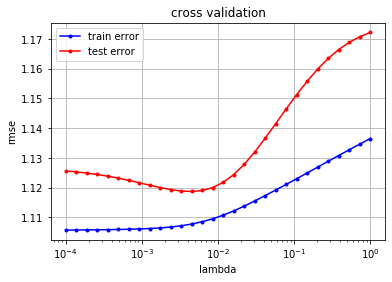

In [135]:
from implementations import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 4
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_clean, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    for i in range(len(lambdas)):
        l = lambdas[i]
        avg_err_tr = 0
        avg_err_te = 0
        for k in range(k_fold):
            err = cross_validation_rr(y_clean, x_clean, k_indices, k, l, degree)
            avg_err_tr += err[0]
            avg_err_te += err[1]
        rmse_tr.append(np.sqrt(2 * avg_err_tr / k_fold))
        rmse_te.append(np.sqrt(2 * avg_err_te / k_fold))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    
    min_err_index = 0
    for i in range(1, len(rmse_te)):
        if rmse_te[i] < rmse_te[min_err_index]:
            min_err_index = i
            
    print('Best lambda is: {0}'.format(lambdas[min_err_index]))       
cross_validation_demo()

## Generate predictions and save ouput in csv format for submission:

In [93]:
DATA_TEST_PATH = '../data/test.csv/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [96]:
OUTPUT_PATH = './leastSquareGD' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(optimal_weights_LS_GD, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)